# Calibrating HBV hydrological model using SCE run locally outside container forced with ERA5 forcing data
In this notebook we will demonstrate how to calibrate the HBV model with Shuffled Complex Evolution (SCE) and works as an example for calibration methods that use a function that needs to be passed to an optimization algorithm. 

Instead of an ensemble of models, we will need to construct a function that does the entire model run.

We will use two new packages not used before:

- the sceua package implements the optimisation algorithm. Infortunately we run into a dependency problem: ESMValTool, which is part of eWaterCycle, requires numpy 1.26.4, sceua requires numpy >= 2. So we install, and subsequently de-install sceua in this notebook.
- the hydrobm package implements common metrics used in hydrology, including the kge, which we use here.  

This assumes you have already seen [the notebook on how to do Monte Carlo calibration in eWaterCycle](step_2a_calibrate_HBV_montecarlo.ipynb)

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import json

# Niceties
from rich import print
from tqdm import tqdm

from util_functions import create_forcing_data_HBV_from_nc

In [2]:
# General eWaterCycle
import ewatercycle
import ewatercycle.models
import ewatercycle.forcing

In [ ]:
# We need the sceua package. If that is not available on your machine,
# uncomment the line below to install it

!pip install sceua

In [4]:
# Sceua package
import sceua

In [ ]:
# # We make use of the hydrobm package to calculate metrics
!pip install hydrobm

In [6]:
from hydrobm.metrics import calculate_metric

In [7]:
# Parameters
region_id = None
settings_path = "settings.json"

In [8]:
# Load settings
# Read from the JSON file
with open(settings_path, "r") as json_file:
    settings = json.load(json_file)

In [9]:
print(settings)

{
    'country': 'Zimbabwe',
    'caravan_id': 'AF_1491830.0',
    'calibration_start_date': '1961-10-01T00:00:00Z',
    'calibration_end_date': '1978-11-21T00:00:00Z',
    'future_start_date': '2029-08-01T00:00:00Z',
    'future_end_date': '2049-08-31T00:00:00Z',
    'base_path': '/home/mmelotto/my_data/workshop_africa',
    'central_data_path': '/data/shared/climate-data/camels_africa/zimbabwe/camel_data',
    'path_shape': 
'/data/shared/climate-data/camels_africa/zimbabwe/camel_data/shapefiles/AF_1491830/AF_1491830.shp',
    'path_caravan': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/caravan',
    'path_ERA5': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/ERA5',
    'path_CMIP6': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/CMIP6',
    'path_output': '/home/mmelotto/my_data/workshop_africa/output_data/AF_1491830.0',
    'hbv_parameters': [10.0, 0.87, 592.0, 1.4, 0.3, 1.0, 0.09, 0.01, 0.001]
}

# Pre-generated observations of discharge from caravan
Here we re-load the disharge data we generated in [this](step_0a_select_caravan_region_time_and_scenarios.ipynb) notebook.

In [10]:
# Load the caravan forcing object
caravan_data_object  = create_forcing_data_HBV_from_nc(settings["calibration_start_date"], settings["calibration_end_date"], settings["caravan_id"], settings["country"])
print(caravan_data_object)

LumpedMakkinkForcing(
    start_time='1961-10-01T00:00:00Z',
    end_time='1978-11-21T00:00:00Z',
    directory=PosixPath('/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/caravan'),
    shape=PosixPath('/data/shared/climate-data/camels_africa/zimbabwe/camel_data/shapefiles/AF_1491830/AF_1491830.s
hp'),
    filenames={
        'pr': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/caravan/pr.nc',
        'rsds': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/caravan/rsds.nc',
        'tas': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/caravan/tas.nc',
        'evspsblpot': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/caravan/evspsblpot.nc',
        'Q': '/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/caravan/Q.nc'
    }
)

## Pre-generated ERA5 forcing data for HBV model
Here we load the ERA5 data we generated in [this](step_1a_generate_historical_forcing) notebook

In [11]:
load_location = Path(settings['path_ERA5']) / "work" / "diagnostic" / "script" 
ERA5_forcing_object = ewatercycle.forcing.sources["LumpedMakkinkForcing"].load(directory=load_location)

In [12]:
print(ERA5_forcing_object)

LumpedMakkinkForcing(
    start_time='1961-10-01T00:00:00Z',
    end_time='1978-11-21T00:00:00Z',
    directory=PosixPath('/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/ERA5/work/diagnostic/scri
pt'),
    shape=PosixPath('/home/mmelotto/my_data/workshop_africa/forcing_data/AF_1491830.0/ERA5/work/diagnostic/script/A
F_1491830.shp'),
    filenames={
        'pr': 'OBS6_ERA5_reanaly_1_day_pr_1961-1978.nc',
        'tas': 'OBS6_ERA5_reanaly_1_day_tas_1961-1978.nc',
        'rsds': 'OBS6_ERA5_reanaly_1_day_rsds_1961-1978.nc',
        'evspsblpot': 'Derived_Makkink_evspsblpot.nc'
    }
)

## Calibration basics and objective function
In model calibration, we are looking for a set of parameters such that when the model is run with that set of parameters, we get the best model output. What "best" means differs per application or research question. In general, we like some model outputs to be as close as possible to observations. For this purpose we create an objective function that takes the model output of interest and observations as inputs and calculates some score that shows goodness of fit. Here we use a RMS difference function:

In [13]:
def calibrationObjective(model_output, observation, start_calibration, end_calibration, metric_name = 'rmse'):
    '''A function that takes in two dataFrames, interpolates the model output to the
    observations and calculates the average absolute difference between the two. '''

    # Combine the two in one dataFrame and interpolate, to make sure times match
    hydro_data = pd.concat([model_output.reindex(observation.index, method = 'ffill'), observation], axis=1,
                           keys=['model','observation'])

    # Only select the calibration period
    hydro_data = hydro_data[hydro_data.index > pd.to_datetime(pd.Timestamp(start_calibration).date())]
    hydro_data = hydro_data[hydro_data.index < pd.to_datetime(pd.Timestamp(end_calibration).date())]

    obs = hydro_data['observation'].to_numpy()
    sim = hydro_data['model'].to_numpy()

    metric_value  = calculate_metric(obs,sim,metric_name)

    return metric_value

    # match metric:
    #     case 'rmse':
    #         # Calculate mean absolute difference
    #         squareDiff = (sim - obs)**2
    #         rmse = np.sqrt(np.mean(squareDiff))
    #         return rmse
    #     case 'nse':
    #         # Calculate Nash Shutcliff Efficiency
    #         nse = 1 - np.sum((obs - sim) ** 2) / np.sum((obs - np.mean(obs)) ** 2)
    #         return nse
    #     case 'kge':
    #         # Calculate Kling Gupta Efficiency
    #         if (np.std(obs) == 0) or (np.std(sim) == 0):
    #             r = 0
    #         else:
    #             r = np.corrcoef(obs, sim)[0, 1]
    #         alpha = np.std(sim) / np.std(obs)
    #         beta = np.mean(sim) / np.mean(obs)
    #         kge = 1 - np.sqrt((r - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)
    #         return kge


## Create a function that runs the entire model and evaluates it


In [14]:
# Create an array with parameter values.

# First set minimum and maximum values on the parameters
p_min_initial = np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001,   0.01])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01,   10.0])

p_initial = (p_min_initial + p_min_initial)/2

In [15]:
# Print parameter names and values for first ensemble member
param_names = ["Imax", "Ce", "Sumax", "Beta", "Pmax", "Tlag", "Kf", "Ks", "FM"]
print(list(zip(param_names, np.round(p_initial, decimals=3))))

[
    ('Imax', 0.0),
    ('Ce', 0.2),
    ('Sumax', 40.0),
    ('Beta', 0.5),
    ('Pmax', 0.001),
    ('Tlag', 1.0),
    ('Kf', 0.01),
    ('Ks', 0.0),
    ('FM', 0.01)
]

In [16]:
# Set initial state values
#               Si,  Su, Sf, Ss, Sp
s_0 = np.array([0,  100,  0,  5,  0])

In [17]:
# Create a dataframe for the observations
ds_observation = xr.open_mfdataset([caravan_data_object['Q']]).to_pandas()
ds_observation = ds_observation['Q']

In [18]:
def runModel(params, forcing_object, observations, initial_state, start_calibration, end_calibration):
    # Create model object, notice the forcing object.
    model = ewatercycle.models.HBVLocal(forcing=forcing_object)

    # Create config file in model.setup()
    config_file, _ = model.setup(parameters=params, initial_storage=initial_state,
                                start_time = start_calibration, end_time = end_calibration)
    # Initialize model
    model.initialize(config_file)
    # Run model, capture calculated discharge and timestamps
    Q_m = []
    time = []
    while model.time < model.end_time:
        model.update()
        Q_m.append(model.get_value("Q")[0])
        time.append(pd.Timestamp(model.time_as_datetime))
    # Finalize model (shuts down container, frees memory)
    model.finalize()

    # Make a pandas series
    model_output = pd.Series(data=Q_m, name="Modelled discharge", index=time)

    return model_output

In [19]:
def runModelReturnObjective(params, forcing_object, observations, initial_state, start_calibration, end_calibration):

    model_output = runModel(params, forcing_object, observations, initial_state, start_calibration, end_calibration)

    kge = calibrationObjective(model_output, observations, start_calibration, end_calibration, metric_name = 'kge')

    # kge is best if high, so we do one minus kge to make sure that sce optimizes correctly
    # since sce always minimizes

    score = 1 - kge

    return score

## Find best parameter set
By calculating the objective function for each model output, we can search the combination of parameters with the lowest objective function.

In [20]:
# Define parameter bounds as a sequence of (min, max) pairs
bounds = [(p_min_initial[n], p_max_initial[n]) for n in range(len(p_min_initial))]

print(bounds)



[
    (0.0, 8.0),
    (0.2, 1.0),
    (40.0, 800.0),
    (0.5, 4.0),
    (0.001, 0.3),
    (1.0, 10.0),
    (0.01, 0.1),
    (0.0001, 0.01),
    (0.01, 10.0)
]

In [21]:
# Run optimization
result = sceua.minimize(runModelReturnObjective, bounds, args=(ERA5_forcing_object, ds_observation, s_0, settings['calibration_start_date'],
                                                              settings['calibration_end_date']), seed=42, max_workers=1)


In [22]:
# Access the optimization results
best_params = result.x
best_function_value = result.fun
num_iterations = result.nit
num_function_evaluations = result.nfev

In [23]:
print(best_function_value)

0.3440364214123721

In [24]:
model_output = runModel(best_params, ERA5_forcing_object, ds_observation, s_0, 
                                              settings['calibration_start_date'], settings['calibration_end_date'])

In [25]:
# Create a dataframe for the observations
ds_observation = xr.open_mfdataset([caravan_data_object['Q']]).to_pandas()

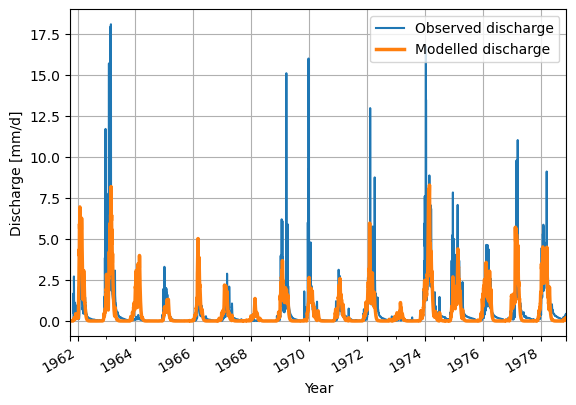

In [26]:
# Make a plot of the model output of the minimum value
ds_observation["Q"].plot(label="Observed discharge")
ax = model_output.plot(lw=2.5,label="Modelled discharge")

plt.legend()
plt.grid()
plt.ylabel("Discharge [mm/d]")
plt.xlabel("Year")
plt.show()

In [27]:
df_best = model_output

In [28]:
df_best.index = df_best.index.tz_localize("UTC")

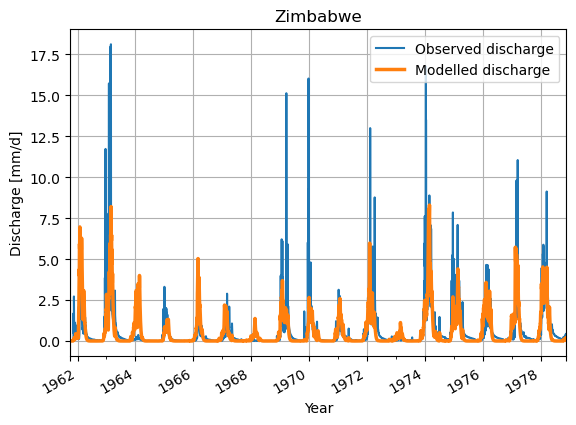

In [29]:
# Make a plot of the model output of the minimum value
ds_observation["Q"].plot(label='Observed discharge')
ax = df_best.plot(lw=2.5, label="Modelled discharge")

plt.legend()
plt.grid()
plt.title(f"{settings["country"]}")
plt.ylabel("Discharge [mm/d]")
plt.xlabel("Year")
plt.show()

## Save results
We want to save these results to file to be able to load them in other studies.

In [30]:
settings["SCE_calibration_parameters"] = list(best_params)

In [31]:
# Write to a JSON file
with open("settings.json", "w") as json_file:
    json.dump(settings, json_file, indent=4)

In [32]:
# Remove all temporary directories made by the optimization algo.

!rm -rf hbvlocal_*

In [ ]:
# Re-install correct numpy for ESMVAlTool
!pip install esmvaltool